# South African Language Identification 

South Africa is a multiethnic country known for its extensive language diversity. The power of language to advance democracy and improve the social, cultural, intellectual, economic, and political spheres of South African society makes it an essential weapon.

There are 11 official languages in the nation, all of which are given equal recognition. The majority of South Africans speak two or more of the official languages and are multilingual.

In [191]:
# Pre Processing
import nltk
import pandas as pd 
import numpy as np
import matplotlib.pyplot as  plt
import seaborn as sns
import re 
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer 
from sklearn.utils import resample

# Model building 
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import TreebankWordTokenizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import sklearn

# Model evaluation
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score


In [192]:
# Loading the dataset
df_train = pd.read_csv("train_set.csv")
df_test = pd.read_csv("test_set.csv")

In [193]:

type_labels = list(df_train.lang_id.unique())
print(type_labels)

['xho', 'eng', 'nso', 'ven', 'tsn', 'nbl', 'zul', 'ssw', 'tso', 'sot', 'afr']


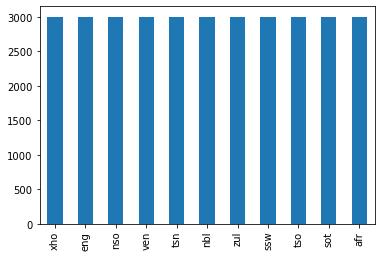

In [194]:
df_train['lang_id'].value_counts().plot(kind = 'bar')
plt.show()

In [195]:
#Looking at the first entries of the train data
df_train.head()

,lang_id,text
0,xho,umgaqo-siseko wenza amalungiselelo kumaziko ax...
1,xho,i-dha iya kuba nobulumko bokubeka umsebenzi na...
2,eng,the province of kwazulu-natal department of tr...
3,nso,o netefatša gore o ba file dilo ka moka tše le...
4,ven,khomishini ya ndinganyiso ya mbeu yo ewa maana...


In [196]:
#having alook at the first entries of the testdataset
df_test.head()

,index,text
0,1,"Mmasepala, fa maemo a a kgethegileng a letlele..."
1,2,Uzakwaziswa ngokufaneleko nakungafuneka eminye...
2,3,Tshivhumbeo tshi fana na ngano dza vhathu.
3,4,Kube inja nelikati betingevakala kutsi titsini...
4,5,Winste op buitelandse valuta.


In [197]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33000 entries, 0 to 32999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   lang_id  33000 non-null  object
 1   text     33000 non-null  object
dtypes: object(2)
memory usage: 515.8+ KB


# Pre-processing

## Data Cleaning

In [198]:
def pre_processing(data): 

    
    """This function removes noise from a dataframe containing text data.  It removes  all   numerical
       values, as well as all occurences of non-ascii characters, all using predefined
       regex expressions from the re library.  It also removes punctuation,  using the `punctuation` method from the string library, and finally, it 
       changes all the text data into lowercase form
       
       Parameters
       ----------
       data : <class 'pandas.core.frame.DataFrame'>
          The dataframe with text data that needs to be cleared of noise
           
       Returns
       -------
       list : 
           A clean list  that has been cleared of noise
       """
    # Empty list to store the clean texts
    Clean_texts = []
    
    for text in range(len(data)):
        texts=re.sub(r'(https?://)?(www\.)?(\w+\.)?(\w+)(\.\w+)(/.+)?',' ',data.iloc[text])
        texts=re.sub('[^a-zA-Z]',' ',texts)
        # changeing all the texts to lower case
        texts=texts.lower().split()
        texts=' '.join(texts)
        # appending a list of clean texts
        Clean_texts.append(texts)
        # removing puntuation
        pun = ''.join([text for text in texts if text not in string.punctuation])   
    return Clean_texts

Creating a copy of our original data, to allow us to make changes without affecting the original data

In [199]:
#Creating new dataframe from a copy of original train data 
df_train_clean = df_train.copy()

# View of the first 500 words in the train'text' data at a list 
''.join(list(df_train_clean['text']))[:500]

'umgaqo-siseko wenza amalungiselelo kumaziko axhasa ulawulo lwesininzi kunye nokuthath inxaxheba kwabafazi ezi ziquka phakathi kwezinye zazo ikomishoni yokulingana ngokwesini ikomishoni yamalungelo oluntu lomzantsi afrikai-dha iya kuba nobulumko bokubeka umsebenzi naphi na kwisebe ngokusekwe kwiimfuno zokusebenza zalo emva kokubonana nomsebenzi kunye okanye imanyano yakhe ukuba ulandulo lomntu onjalo alufanelekanga i-dha mayibize uncedo olufanelekileyo elungelweni layothe province of kwazulu-nata'

The most for the noise has been removed from the data, the tada looks good!

In [200]:
#Creating new dataframe from a copy of original test data 
df_test_clean = df_test.copy()

# View of the first 500 words in the train'text' data at a list 
''.join(list(df_train_clean['text']))[:500]

'umgaqo-siseko wenza amalungiselelo kumaziko axhasa ulawulo lwesininzi kunye nokuthath inxaxheba kwabafazi ezi ziquka phakathi kwezinye zazo ikomishoni yokulingana ngokwesini ikomishoni yamalungelo oluntu lomzantsi afrikai-dha iya kuba nobulumko bokubeka umsebenzi naphi na kwisebe ngokusekwe kwiimfuno zokusebenza zalo emva kokubonana nomsebenzi kunye okanye imanyano yakhe ukuba ulandulo lomntu onjalo alufanelekanga i-dha mayibize uncedo olufanelekileyo elungelweni layothe province of kwazulu-nata'

### Test data

## Features Selecting

### fetures

In [201]:
# The label, y, is defined as the 'lang_id' column in the dataframe, train_data
y = df_train_clean['lang_id']
# The freatures, X, are defined as the 'text' column in the dataframe, train_data
X = df_train_clean['text']
# Looking at the shape of the label and freatures
print(X.shape) # features
print(y.shape) # label

(33000,)
(33000,)


In [209]:
# Cleaning the trained 
df_train_cleand = pre_processing(df_train_clean['text'])
df_test_cleand = df_test['text']


In [210]:
X_cleaned = df_train_cleand


In [204]:
type_labels = ['afr : Afrikaans'
               'eng : English',
               'nbl  : isiNdebele',   
                'nso : Sepedi',
                'sot : Sesotho',
                'ssw : siSwati',  
                'tsn : Setswana',
                'tso : Xitsonga',
                'ven : Tshivenda',  
                'xho : isiXhosa',
                'zul : isiZulu']

In [205]:

X_train, X_test, y_train, y_test = train_test_split(X_cleaned, y, test_size = 0.2 , random_state = 42)

In [206]:
TDIF_vector= TfidfVectorizer(max_df=0.9, ngram_range=(1, 5), analyzer= 'char',max_features=10000)

X_train = TDIF_vector.fit_transform(X_train).toarray() 
X_test = TDIF_vector.transform(X_test).toarray()

In [207]:
mnb_model = MultinomialNB()

mnb_model.fit(X_train, y_train)

predicts = mnb_model.predict(X_test)

f1score = f1_score(y_test, predicts, average= 'weighted')
print(f1score)

0.9978790422961998


In [211]:
X_test = df_test_cleand
pred_X = TDIF_vector.transform(X_test).toarray()
predicted_values = mnb_model.predict(pred_X)

In [ ]:
# Extract the index column from test_data to use as the submission file index
index = df_test_cleand['index']

In [ ]:
# Create a dataframe of index and and the predicted language
submission_logreg = pd.DataFrame({'index' : index, 'lang_id' : predicted_values})

In [ ]:
submission_logreg.to_csv("Submission_mulg.csv", index = False)